#Evaluate the depth and area averaged temp timeseries in JRA-55 ACCESS=OM2-01-IAF runs

In [68]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath


import scipy as sp
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame

import statsmodels.api as sm

import xesmf as xe

In [69]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37695/status,
Dashboard: /proxy/37695/status,Workers: 4
Total threads: 8,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41359,Workers: 4
Dashboard: /proxy/37695/status,Total threads: 8
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:43483,Total threads: 2
Dashboard: /proxy/41437/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:42999,


In [70]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

In [71]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1).sel(yt_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
ht.load()
print(ht.shape)

expt='01deg_jra55v140_iaf'
variable='hu'
hu = cc.querying.getvar('01deg_jra55v140_iaf','hu',session,n=1).sel(yu_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
hu.load()
print(hu.shape)

(584, 3600)
(583, 3600)


In [72]:
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,session, n=-1)
xt_ocean.load()
print(xt_ocean.values)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,session, n=-1)
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,session, n=-1)#.fillna(1.0).astype(int) - 1
area_t.load()
print(area_t.shape)

[-279.95 -279.85 -279.75 ...   79.75   79.85   79.95]
(2700,)
(2700, 3600)


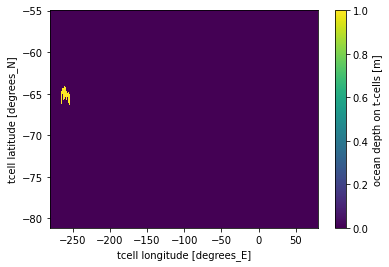

In [73]:
#var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True

tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#plt.xlim([-265,-254])
den_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
den_mask = den_mask.where(~xr.ufuncs.isfinite(den_mask.where(yt_ocean>-60)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean<-265)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean>-254)))
den_mask = ~xr.ufuncs.isnan(den_mask).to_dataset(name='den_mask')

den_mask.den_mask.plot()

In [74]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

In [75]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [76]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries ...???
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5) #end effects? I don't understand this line.
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = scipy.stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = scipy.stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = scipy.stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2

In [77]:
yrs=np.arange(1958.5,2019.5,1)

In [78]:
dm_t_200to500=np.load('../data/dm_temp_01_cycle2to3_200to500_5801to1812.npy')
print(dm_t_200to500.shape)

dm_t_200to1000=np.load('../data/dm_temp_01_cycle2to3_200to1000_5801to1812.npy')
print(dm_t_200to1000.shape)


(2, 61)
(2, 61)


In [79]:
#5 yr rolling mean of mcm temp data
df= pd.DataFrame(np.mean(dm_t_200to500[:,:],axis=0))
dm_t_200to500_5yr = df.rolling(window=5, center=True).mean().values
print(dm_t_200to500.shape,dm_t_200to500_5yr.shape)


df= pd.DataFrame(np.mean(dm_t_200to1000[:,:],axis=0))
dm_t_200to1000_5yr = df.rolling(window=5, center=True).mean().values
print(dm_t_200to1000.shape,dm_t_200to1000_5yr.shape)#,dm_t_200to1000_5yr)

(2, 61) (61, 1)
(2, 61) (61, 1)


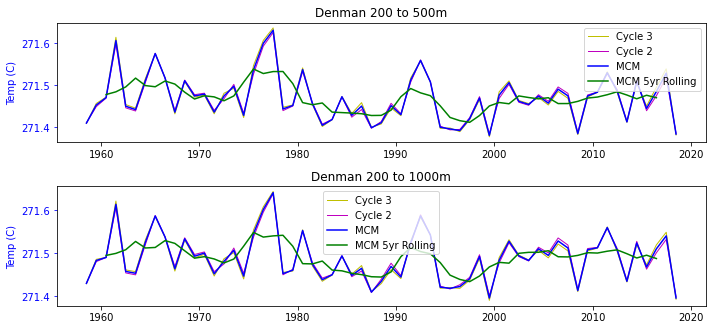

In [80]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958.5,2019.5,1)

fig = plt.figure(figsize=(10, 9))

ax1=plt.subplot(411)
ax1.plot(yrs,dm_t_200to500[1,:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(yrs,dm_t_200to500[0,:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(yrs,np.mean(dm_t_200to500[:,:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MCM')
ax1.plot(yrs,dm_t_200to500_5yr,linestyle='-',color='g',linewidth=1.5,label='MCM 5yr Rolling')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Denman 200 to 500m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(412)
ax1.plot(yrs,dm_t_200to1000[1,:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(yrs,dm_t_200to1000[0,:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(yrs,np.mean(dm_t_200to1000[:,:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MCM')
ax1.plot(yrs,dm_t_200to1000_5yr,linestyle='-',color='g',linewidth=1.5,label='MCM 5yr Rolling')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Denman 200 to 1000m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

plt.tight_layout()

In [81]:
yrs[36]

1994.5

In [82]:
#look for wind correlations now
txx=[]

f=xr.open_dataset('../../ensoant/data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
txx.append(f.tau_x)

f=xr.open_dataset('../../ensoant/data/taux_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
txx.append(f.tau_x)

txx=np.asarray(txx)
print(txx.shape)

(2, 61, 583, 3600)


#Temp Taux correlations 
myr=36 #12,22,36
#take mmm and just 1994-2018 or do 1980-2018
txx_mmm=np.mean(txx[:,myr:,:,:],axis=0)
print(txx_mmm.shape)

#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, txx_mmm.shape[1], txx_mmm.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean temp on averaged shelf
a=np.mean(dm_t_200to1000[:,myr:],axis=0)

for j in range(0,txx_mmm.shape[1]):
    #if j % 100 == 0:
    print(j)
    
    for i in range(0,txx_mmm.shape[2]):
        
        b=txx_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('../data/allstats2d_taux_w_dmtemp_01deg_94to18.nc.npy',allstats2d)

In [83]:
i

1047

(4, 583, 3600)
(4, 583, 3600)


Text(0.5, 1.0, '1980 to 2018 Taux/DMTemp Best Lag')

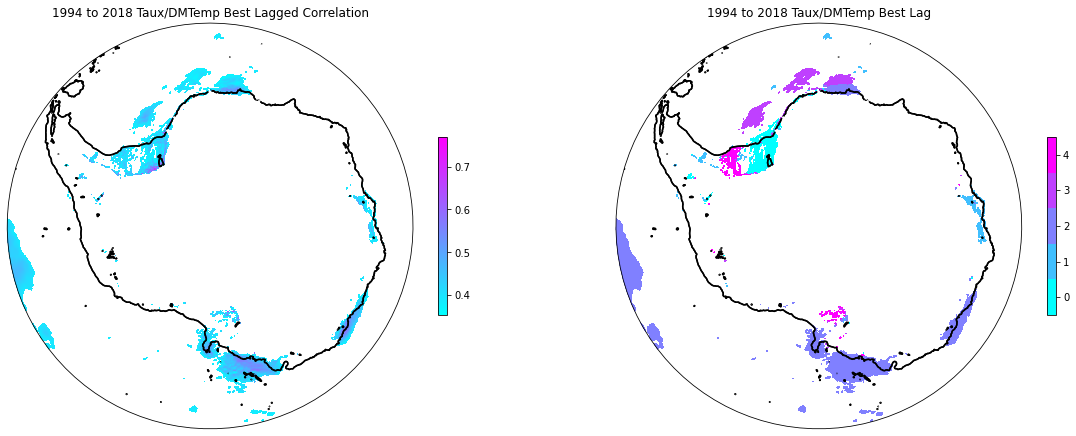

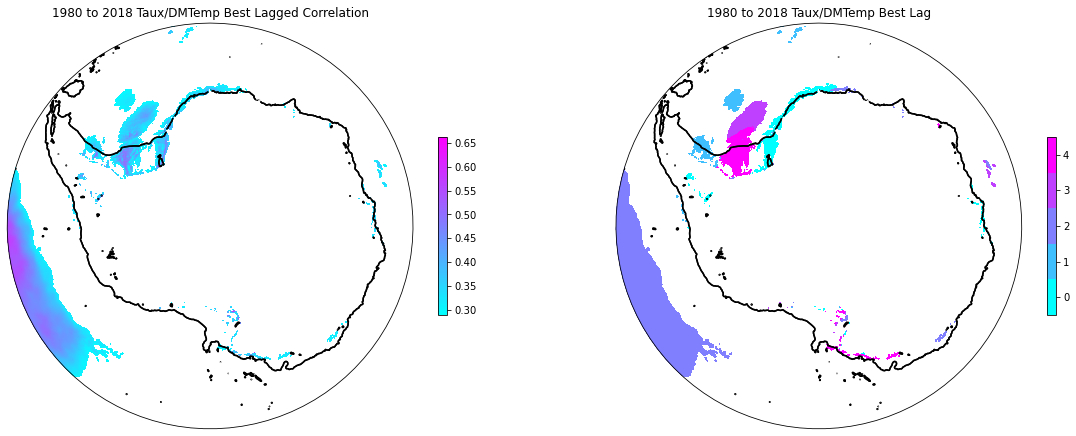

In [84]:
f=xr.open_dataset('../../ensoant/data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
allstats2d_xr=f.tau_x.mean(dim='time').load()

allstats2d=np.load('../data/allstats2d_taux_w_dmtemp_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1994 to 2018 Taux/DMTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1994 to 2018 Taux/DMTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))

allstats2d=np.load('../data/allstats2d_taux_w_dmtemp_01deg_80to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 3, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1980 to 2018 Taux/DMTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 4, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1980 to 2018 Taux/DMTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 583, 3600)


Text(0.5, 1.0, 'Taux/DMTemp Best Lag')

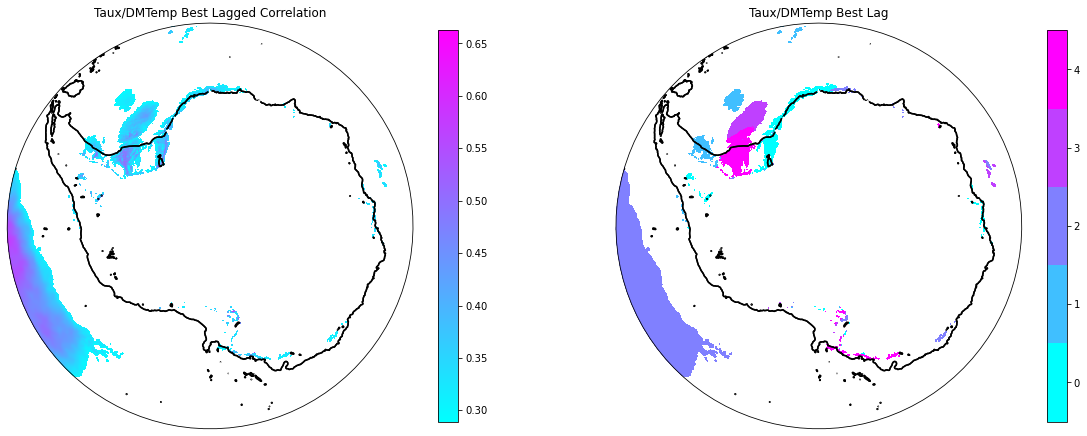

In [85]:
allstats2d=np.load('../data/allstats2d_taux_w_dmtemp_01deg_80to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Taux/DMTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
#ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
#ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('Taux/DMTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


In [86]:
#Look at SACCF front position correlations
saccf=np.load('../data/01iafAS1.8Clines.npy')
saccf.shape

(61, 2)

In [87]:
df= pd.DataFrame(np.mean(saccf[:,:],axis=1))
saccf_5yr = df.rolling(window=5, center=True).mean().values
print(saccf.shape,saccf_5yr.shape)#,dm_t_200to1000_5yr)

(61, 2) (61, 1)


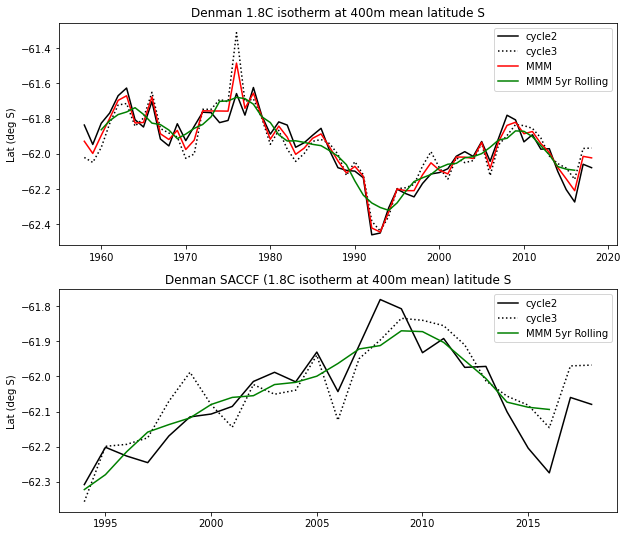

In [88]:
yrs=np.arange(1958,2019)
  
fig = plt.figure(figsize=(10, 9))
ax1=plt.subplot(211)
#aa=np.nans(61,1)
ax1.plot(yrs[:],saccf[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],saccf[:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[:],np.mean(saccf,axis=1),linestyle='-',color='r',label='MMM',linewidth=1.5)
ax1.plot(yrs[:],saccf_5yr,linestyle='-',color='g',label='MMM 5yr Rolling',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman 1.8C isotherm at 400m mean latitude S')
ax1.set_ylabel('Lat (deg S)')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

myr=36
ax1=plt.subplot(212)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],saccf[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],saccf[myr:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[myr:],saccf_5yr[myr:],linestyle='-',color='g',label='MMM 5yr Rolling',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman SACCF (1.8C isotherm at 400m mean) latitude S')
ax1.set_ylabel('Lat (deg S)')
ax1.legend(fontsize=10)

In [89]:
saccf.shape
yrs[:]

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

In [90]:
saccf_5yr[myr:]#-np.nanmean(saccf_5yr[myr:])

array([[-62.32204684],
       [-62.27953716],
       [-62.21448628],
       [-62.15835965],
       [-62.13702481],
       [-62.11801914],
       [-62.07973797],
       [-62.0595852 ],
       [-62.0547114 ],
       [-62.02298723],
       [-62.01676708],
       [-61.9991787 ],
       [-61.96303031],
       [-61.92176074],
       [-61.91200507],
       [-61.8699687 ],
       [-61.87227719],
       [-61.90294596],
       [-61.95444732],
       [-62.00579237],
       [-62.07309263],
       [-62.08761847],
       [-62.09393196],
       [         nan],
       [         nan]])

(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61, 1) (61, 1)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


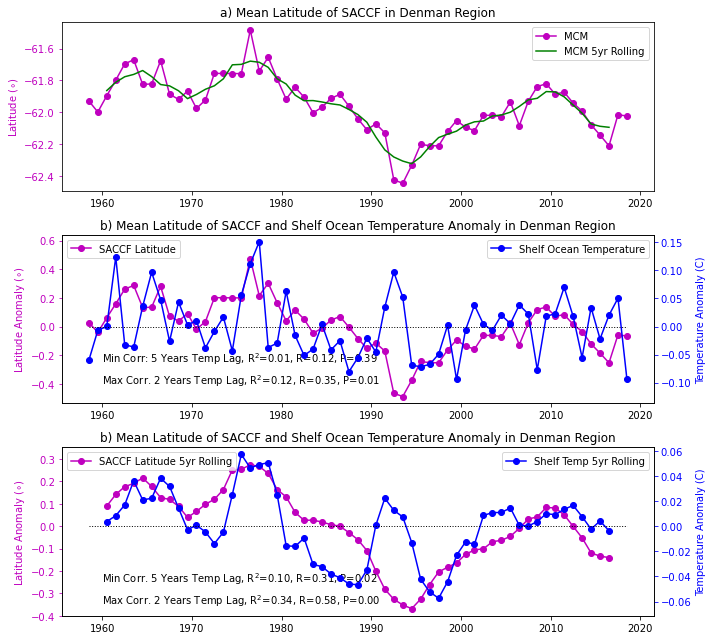

In [105]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=5

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)



ax1=plt.subplot(311)
#ax1.plot(yrs[:],np.mean(saccf[:,:],axis=1),linestyle='-',color='k',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1),linestyle='-',color='m',marker='o',label='MCM',linewidth=1.5)
ax1.plot(yrs[myr:],saccf_5yr[myr:],linestyle='-',color='g',label='MCM 5yr Rolling',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude ($\circ$)',color='m')
ax1.tick_params('y', colors='m')
plt.title('a) Mean Latitude of SACCF in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t-l_t

#annual mean saccf position
b=np.mean(saccf[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.4,corstr,color='k')


a=dm_t_5yr-np.nanmean(dm_t_5yr)

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],saccf_5yr[myr:]-np.nanmean(saccf_5yr[myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=saccf_5yr[myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[2:-2]),np.squeeze(b[2:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.35,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


(41,) ()
(41,) (41,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(41, 1) (41, 1)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


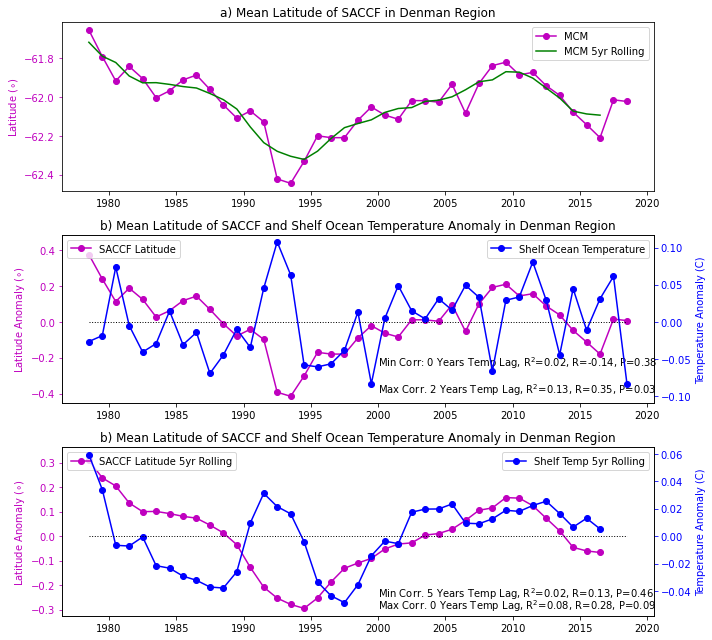

In [121]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=20
maxlag=5

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)



ax1=plt.subplot(311)
#ax1.plot(yrs[:],np.mean(saccf[:,:],axis=1),linestyle='-',color='k',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1),linestyle='-',color='m',marker='o',label='MCM',linewidth=1.5)
ax1.plot(yrs[myr:],saccf_5yr[myr:],linestyle='-',color='g',label='MCM 5yr Rolling',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude ($\circ$)',color='m')
ax1.tick_params('y', colors='m')
plt.title('a) Mean Latitude of SACCF in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t-l_t

#annual mean saccf position
b=np.mean(saccf[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.4,corstr,color='k')


a=dm_t_5yr[myr:]-np.nanmean(dm_t_5yr[myr:])

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],saccf_5yr[myr:]-np.nanmean(saccf_5yr[myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=saccf_5yr[myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[:-2]),np.squeeze(b[:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.3,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


In [92]:
l

array([[5.44804464e-01, 1.17892484e-05],
       [5.80143600e-01, 2.78328159e-06],
       [5.80163401e-01, 3.44371551e-06],
       [5.32150890e-01, 3.45105929e-05],
       [4.43810151e-01, 8.72530850e-04],
       [3.13864372e-01, 2.34586338e-02]])

In [96]:
#Look at Taux=0 front position correlations
tx0=np.load('../data/01iafTx0lines_275to245.npy')
tx0.shape


(61, 2)

In [110]:
#df= pd.DataFrame(hadsst_n34_ann)
#hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
#print(hadsst_n34_ann.shape,hadsst_n34_ann_5yr.shape)

#non-centered rolling ... keep data to 2019 rm center=True
tx0_all = pd.DataFrame(np.mean(tx0,axis=1),columns=['MMM'])
tx0_all
tx0_all['Rolling']=tx0_all['MMM'].rolling(window=5,center=True).mean()
tx0_all
tx0_all['Rolling'][:]

0           NaN
1           NaN
2    -62.034502
3    -62.130219
4    -61.804929
        ...    
56   -62.254671
57   -62.198420
58   -62.174177
59          NaN
60          NaN
Name: Rolling, Length: 61, dtype: float64

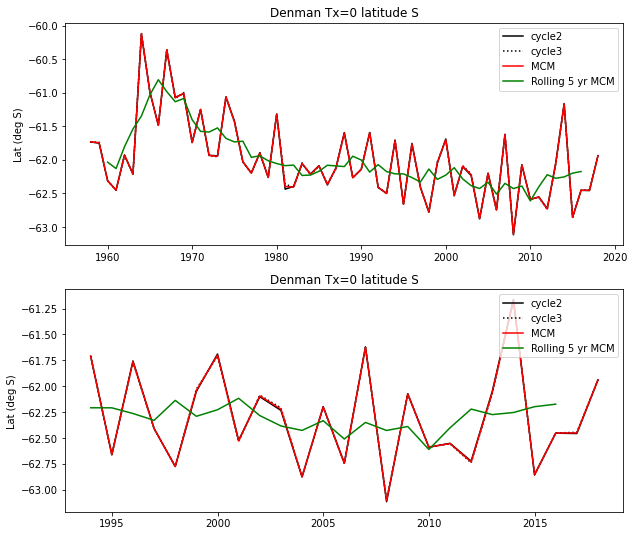

In [111]:
#non-centered rolling ... keep data to 2019
yrs=np.arange(1958,2019)
  
fig = plt.figure(figsize=(10, 9))
ax1=plt.subplot(211)
#aa=np.nans(61,1)
ax1.plot(yrs[:],tx0[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],tx0[:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[:],np.mean(tx0,axis=1),linestyle='-',color='r',label='MCM',linewidth=1.5)
ax1.plot(yrs[:],tx0_all['Rolling'],linestyle='-',color='g',label='Rolling 5 yr MCM',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Tx=0 latitude S')
ax1.set_ylabel('Lat (deg S)')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

myr=36
ax1=plt.subplot(212)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],tx0[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],tx0[myr:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1),linestyle='-',color='r',label='MCM',linewidth=1.5)
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='g',label='Rolling 5 yr MCM',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Denman Tx=0 latitude S')
ax1.set_ylabel('Lat (deg S)')
ax1.legend(fontsize=10)

(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(61, 1) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


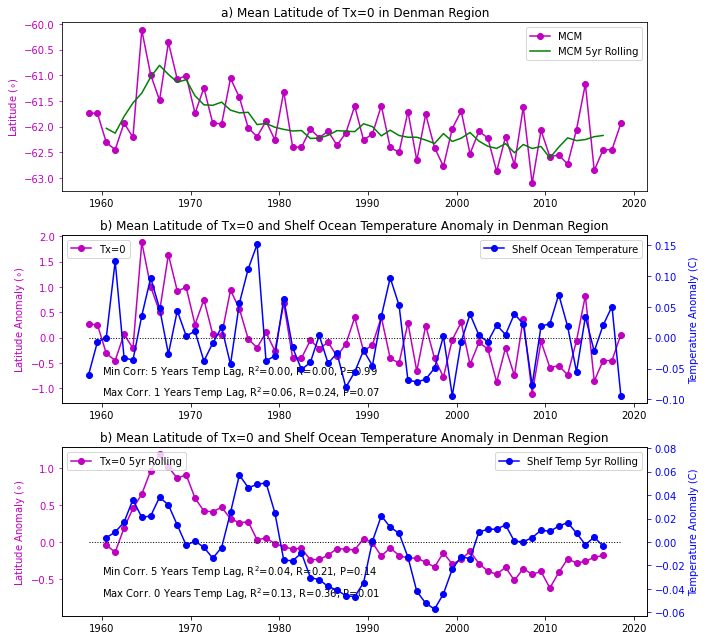

In [129]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=5

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)



ax1=plt.subplot(311)
#ax1.plot(yrs[:],np.mean(saccf[:,:],axis=1),linestyle='-',color='k',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1),linestyle='-',color='m',marker='o',label='MCM',linewidth=1.5)
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='g',label='MCM 5yr Rolling',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude ($\circ$)',color='m')
ax1.tick_params('y', colors='m')
plt.title('a) Mean Latitude of Tx=0 in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='Tx=0')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of Tx=0 and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t-l_t

#annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.75,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that tx0 is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-1.15,corstr,color='k')


a=dm_t_5yr[myr:]-np.nanmean(dm_t_5yr[myr:])

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.nanmean(tx0_all['Rolling'][myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='Tx=0 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of Tx=0 and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=tx0_all['Rolling'][myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[2:-2]),np.squeeze(b[2:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-0.45,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1960,-.75,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


(41,) ()
(41,) (41,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(41, 1) (41,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


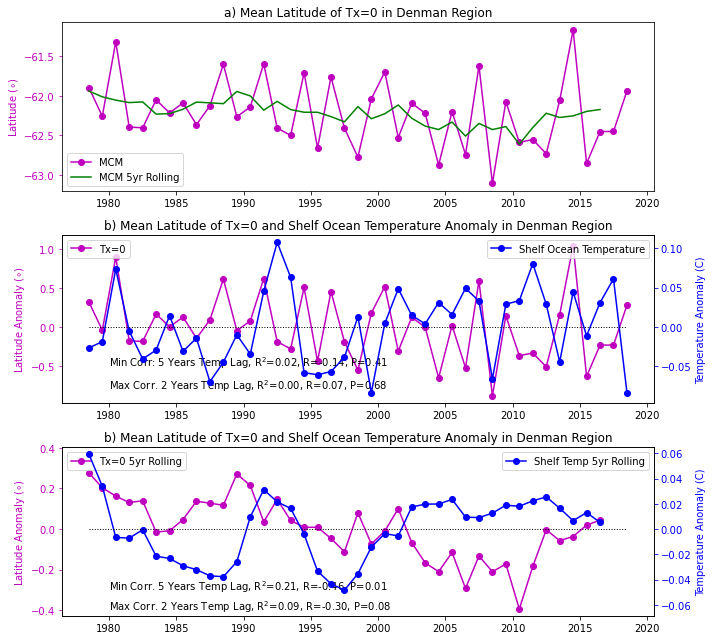

In [133]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=20
maxlag=5

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)



ax1=plt.subplot(311)
#ax1.plot(yrs[:],np.mean(saccf[:,:],axis=1),linestyle='-',color='k',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1),linestyle='-',color='m',marker='o',label='MCM',linewidth=1.5)
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='g',label='MCM 5yr Rolling',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude ($\circ$)',color='m')
ax1.tick_params('y', colors='m')
plt.title('a) Mean Latitude of Tx=0 in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='Tx=0')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of Tx=0 and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t-l_t

#annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr: %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-0.5,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that tx0 is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-.8,corstr,color='k')


a=dm_t_5yr[myr:]-np.nanmean(dm_t_5yr[myr:])

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.nanmean(tx0_all['Rolling'][myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='Tx=0 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of Tx=0 and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=tx0_all['Rolling'][myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[2:-2]),np.squeeze(b[2:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-0.3,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-.4,corstr,color='k')


plt.tight_layout()

#of = '../data/SACCF_Temp.png'
#plt.savefig(of,dpi=220)


(41,) (41, 1)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(41, 1) (41, 1)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(41, 1) (41,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


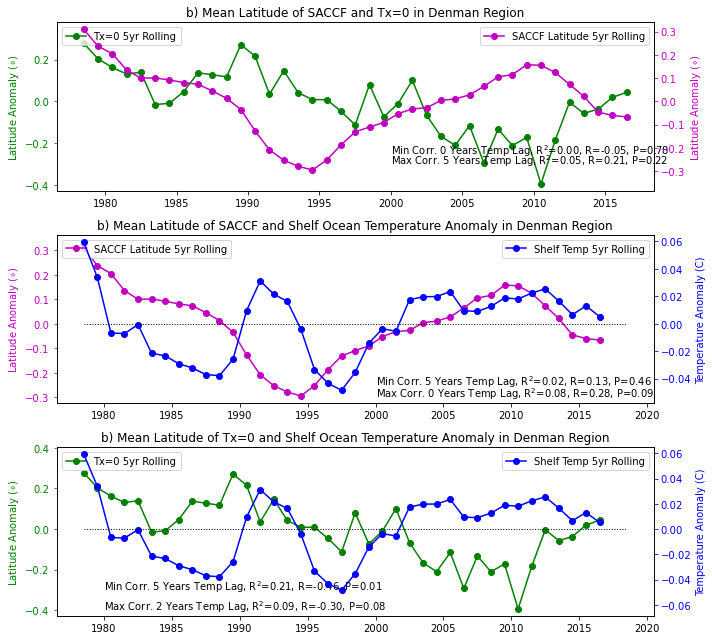

In [140]:
yrs=np.arange(1958.5,2019.5)

myr=20
maxlag=5

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))


ax1=plt.subplot(311)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.nanmean(tx0_all['Rolling'][myr:]),linestyle='-',color='g',marker='o',linewidth=1.5, label='Tx=0 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='g')
plt.title('b) Mean Latitude of SACCF and Tx=0 in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],saccf_5yr[myr:]-np.nanmean(saccf_5yr[myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude 5yr Rolling')
ax2.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='m')
#ax1.set_xlabel('Years')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#lagged cor, a lags b
b=saccf_5yr[myr:]
a=tx0_all['Rolling'][myr:]
print(a.shape,b.shape)
l=lagcorr(np.squeeze(a[:-2]),np.squeeze(b[:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.3,corstr,color='k')


a=dm_t_5yr[myr:]-np.nanmean(dm_t_5yr[myr:])

ax1=plt.subplot(312)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],saccf_5yr[myr:]-np.nanmean(saccf_5yr[myr:]),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=saccf_5yr[myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[:-2]),np.squeeze(b[:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.25,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2000,-0.3,corstr,color='k')

a=dm_t_5yr[myr:]-np.nanmean(dm_t_5yr[myr:])

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.nanmean(tx0_all['Rolling'][myr:]),linestyle='-',color='g',marker='o',linewidth=1.5, label='Tx=0 5yr Rolling')
ax1.set_ylabel('Latitude Anomaly ($\circ$)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='g')
plt.title('b) Mean Latitude of Tx=0 and Shelf Ocean Temperature Anomaly in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],a,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Temp 5yr Rolling')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

#annual mean saccf position
b=tx0_all['Rolling'][myr:]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(np.squeeze(a[2:-2]),np.squeeze(b[2:-2]),maxlag)

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Min Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-0.3,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

## Weird that SACCF is positively correlated with shelf temp ... should be negatively correlated
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="Max Corr. %.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-.4,corstr,color='k')


plt.tight_layout()


In [69]:
#df= pd.DataFrame(hadsst_n34_ann)
#hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
#print(hadsst_n34_ann.shape,hadsst_n34_ann_5yr.shape)

#non-centered rolling ... keep data to 2019
tx0_all = pd.DataFrame(np.mean(tx0,axis=1),columns=['MMM'])
tx0_all
tx0_all['Rolling']=tx0_all['MMM'].rolling(window=5, center=True).mean()
tx0_all
tx0_all['Rolling'][:]

0           NaN
1           NaN
2    -62.034502
3    -62.130219
4    -61.804929
        ...    
56   -62.254671
57   -62.198420
58   -62.174177
59          NaN
60          NaN
Name: Rolling, Length: 61, dtype: float64

(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]


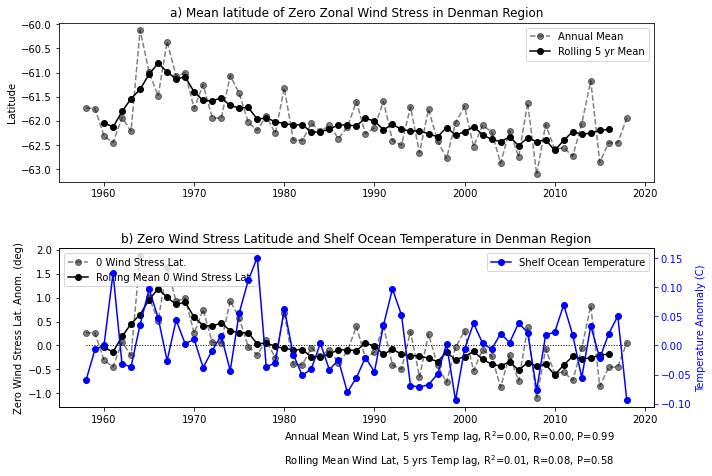

In [70]:
#Rolling mean = centered =2 ... lose lat 2 datapoints

#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
myr=0
maxlag=10

dm_t=dm_t_200to1000
dm_t_5yr=dm_t_200to1000_5yr

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(dm_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

ax1=plt.subplot(311)
ax1.plot(yrs[:],np.mean(tx0[:,:],axis=1),linestyle='--',color='k',marker='o',linewidth=1.5,alpha=0.5,label='Annual Mean')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling 5 yr Mean')

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude',color='k')
#ax1.tick_params('y', colors='b')
plt.title('a) Mean latitude of Zero Zonal Wind Stress in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='--',color='k',alpha=0.5,marker='o',linewidth=1.5,label='0 Wind Stress Lat.')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.mean(tx0_all['Rolling'][myr:]),linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling Mean 0 Wind Stress Lat.')
ax1.set_ylabel('Zero Wind Stress Lat. Anom. (deg)',color='k')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='k')
plt.title('b) Zero Wind Stress Latitude and Shelf Ocean Temperature in Denman Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

a=ts_t-l_t

#annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Annual Mean Wind Lat, %.0f yrs Temp lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-2.,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,2.,corstr,color='k')

#cycle mean of annual mean saccf position #use -2 if rolling centered
b=tx0_all['Rolling'][myr+4:-2]

#lagged cor, a lags b
l=lagcorr(a[4:-2],b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Rolling Mean Wind Lat, %.0f yrs Temp lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-2.5,corstr,color='k')
#


plt.tight_layout()

of = 'data/Tx0_Temp_DMmelt.png'
#plt.savefig(of,dpi=220)